# Notebook donde se muestra el manejo de algunas señales...

* Señalea de velocidad, Torque y Posición
* EMG
* ECG
    - HRV
* Pletismografia (proveniente de una banda de respiración de biopac SSL07)
* EEG
    - BPTs


# Importación liberias

In [1]:
# Librería donde se encuentran algunas funciones de Erik Bojorges y mias para el procesamiento de señales
import iberoSignalPro.preprocesa as ib

# Librería para leer archivos de BCI2000
from BCI2kReader import BCI2kReader as b2k

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as sgnl
from scipy.interpolate import interp1d
import mne
import os


In [2]:
%matplotlib inline

In [3]:
ls ..

 El volumen de la unidad C no tiene etiqueta.
 El n�mero de serie del volumen es: E2F7-D53B

 Directorio de c:\Users\fercy\OneDrive\Escritorio\InternadoFMM\EEG-SelExcecuted-Assisted

25/12/2024  09:05 p. m.    <DIR>          .
25/12/2024  09:05 p. m.    <DIR>          ..
25/12/2024  08:59 p. m.    <DIR>          DataPrep
25/12/2024  08:56 p. m.    <DIR>          NetworkAnalysis
25/12/2024  08:56 p. m.    <DIR>          PowerAnalysis
25/12/2024  09:05 p. m.    <DIR>          ToolFiles
               0 archivos              0 bytes
               6 dirs  148,676,861,952 bytes libres


In [4]:

directory = '../../Pruebas%20BCI/Sujetos'  
files = os.listdir(directory)
for file in files:
    print(file)
    

AlejandoPayan
AlmaTirado
AndreaBosch
CarlosCastaneira
DianaInfante
ElizabethMorales
GabrielaCastaneira
Isaac
IsabellaVera
Jona
KevinCastro
MauricioServin
PabloRoca
SamuelSanchez
TemanyaReyes
Yunuen


## Se carga el registro:

/Pruebas%20BCI/Nombre_del_sujeto/sesion/ejercicio.dat

In [5]:
def carga_registro(nombre, sesion, ejericio = "10deTorque"):
    filename = '../../Pruebas%20BCI/Sujetos/'+nombre+'/'+sesion+'/'+ejericio + '.dat'

    ### Carga de los datos
    file = b2k.BCI2kReader(filename)
    fs = int(file._samplingrate())
    signals = np.array(file._signals())
    states = (file._states())
    t = np.arange(0, len(signals[0, :]), 1)/fs
    return fs, signals, states, t, filename

In [6]:
fs, signals, states, t, filename = carga_registro('MauricioServin', 'S3', "10deTorque")


## Limpieza de señales

In [7]:
sosemg = sgnl.butter(3, [10*2/fs, 500*2/fs], "band", output="sos")                                                      
sosisok = sgnl.butter(2, [(0.5*2)/fs, (20*2)/fs], "band", output="sos")         


In [8]:
t_min = 0 * fs
t_max = -1

t = np.arange(0, len(signals[1, t_min:t_max])/fs, 1/fs)

pos =  sgnl.sosfiltfilt(sosisok, signals[16, t_min:t_max])
vel = sgnl.sosfiltfilt(sosisok, signals[17, t_min:t_max])
torq = sgnl.sosfiltfilt(sosisok, signals[18, t_min:t_max])


In [9]:
%matplotlib inline

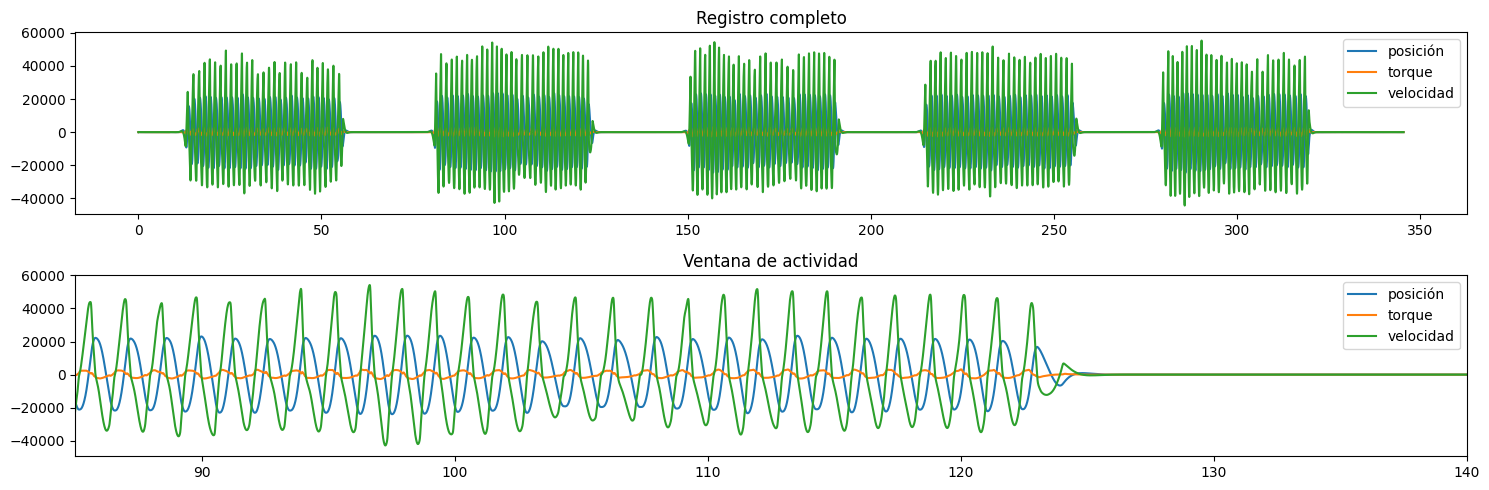

In [10]:
plt.figure(figsize=(15, 5))

# Subplot 1: Registro completo
plt.subplot(2, 1, 1)
plt.title("Registro completo")
plt.plot(t, pos, label="posición")
plt.plot(t, torq, label="torque")
plt.plot(t, vel, label="velocidad")
plt.legend(loc="upper right")

# Subplot 2: Ventana de actividad
plt.subplot(2, 1, 2)
plt.title("Ventana de actividad")
plt.plot(t, pos, label="posición")
plt.plot(t, torq, label="torque")
plt.plot(t, vel, label="velocidad")
plt.xlim(85, 140)
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()


### Obtención de unas señal binaria

In [11]:
def obtener_bin_std(sig, fs=4800, ventana_ej = 8000, thresh = 0.5, siPlot = True):
    
    aux_arr = np.zeros_like(sig)
    
    for i in range(0, len(sig), ventana_ej):
        if (sig[i:i+ventana_ej].std() > thresh):
            aux_arr[i:i+ventana_ej] += 1
        
    binary_sig = aux_arr
    if(siPlot):
        plt.figure(figsize=(20, 5))
        plt.plot(sig)
        plt.plot(binary_sig)
        
    return binary_sig

def obtener_win(sig, binary_sig, siPlot = True):
    diff = np.diff(binary_sig)
    idx_actividad = np.where(diff == 1)[0]
    idx_rep = np.where(diff == -1)[0]

    min_len = min(len(idx_rep), len(idx_actividad))
    idx_rep = idx_rep[:min_len]
    idx_actividad = idx_actividad[:min_len]

    
    ventanas_reposo = np.stack((idx_rep, idx_actividad)).T
    ventanas_actividad = np.stack((idx_actividad, idx_rep)).T

    if idx_rep[0] < idx_actividad[0]:
        ventanas_reposo = np.stack((idx_rep, idx_actividad)).T
        ventanas_actividad = np.stack((idx_actividad[:-1], idx_rep[1:])).T
    else:
        ventanas_reposo = np.stack((idx_rep[:-1], idx_actividad[1:])).T
        ventanas_actividad = np.stack((idx_actividad[:], idx_rep[:])).T

    if(siPlot):
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 2, 1) 
        for ventana in ventanas_actividad:
            plt.plot(sig[ventana[0]: ventana[1]])
        plt.title('Ventanas de actividad')

        plt.subplot(1, 2, 2)  
        for ventana in ventanas_reposo:
            plt.plot(sig[ventana[0]: ventana[1]])
        plt.title('Ventanas de reposo')

        plt.show()

    return ventanas_actividad, ventanas_reposo


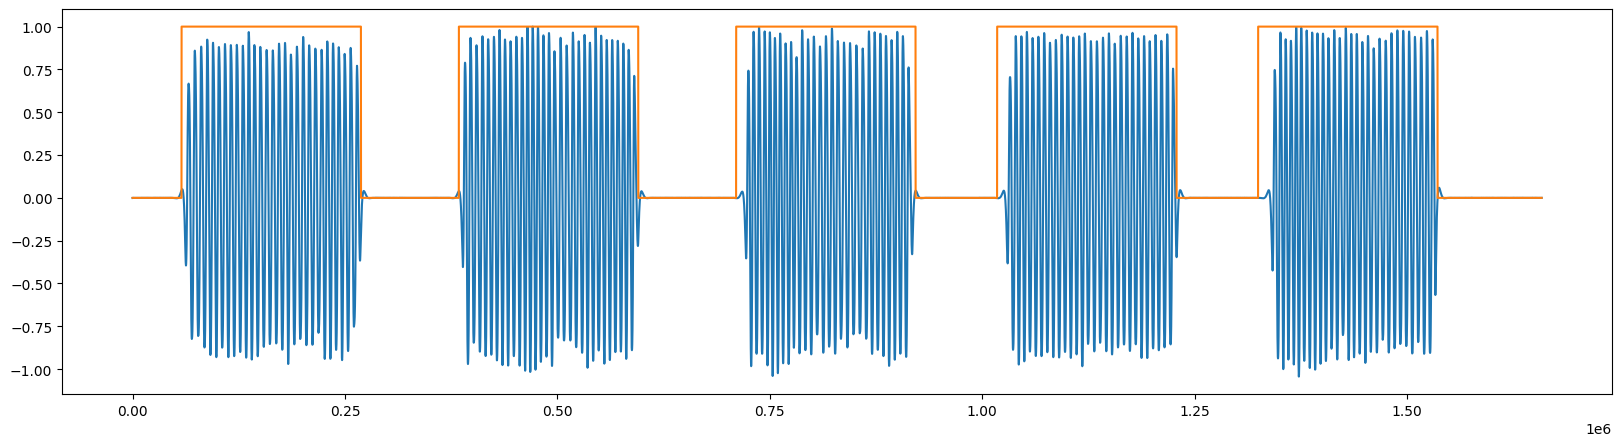

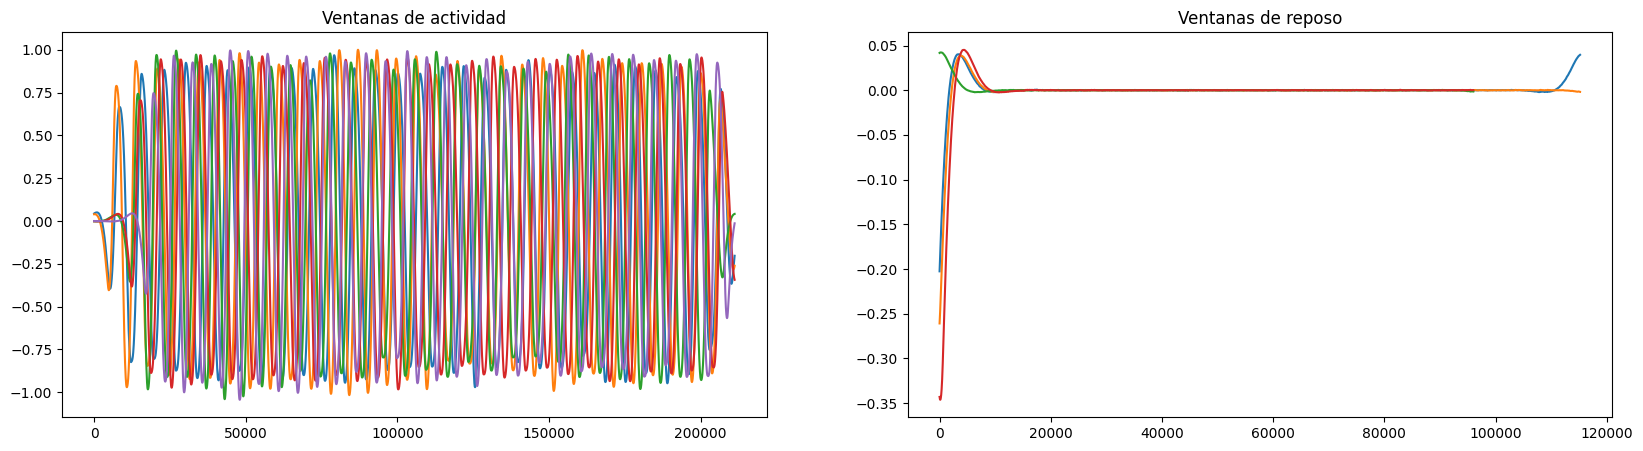

In [12]:
sig = ib.normaliza(pos)
sig = (sig - sig.mean()) / (sig.max() - sig.mean()) 
binary_sig = obtener_bin_std(sig , fs=fs, ventana_ej = int(4 *fs), thresh = 0.08, siPlot = True)
ventanas_actividad, ventanas_reposo = obtener_win(sig, binary_sig, siPlot = True)

In [13]:
old_min = pos.min()
old_max = pos.max()
new_min = 86
new_max = 180

scaled_pos = new_min + (pos - old_min) * (new_max - new_min) / (old_max - old_min)


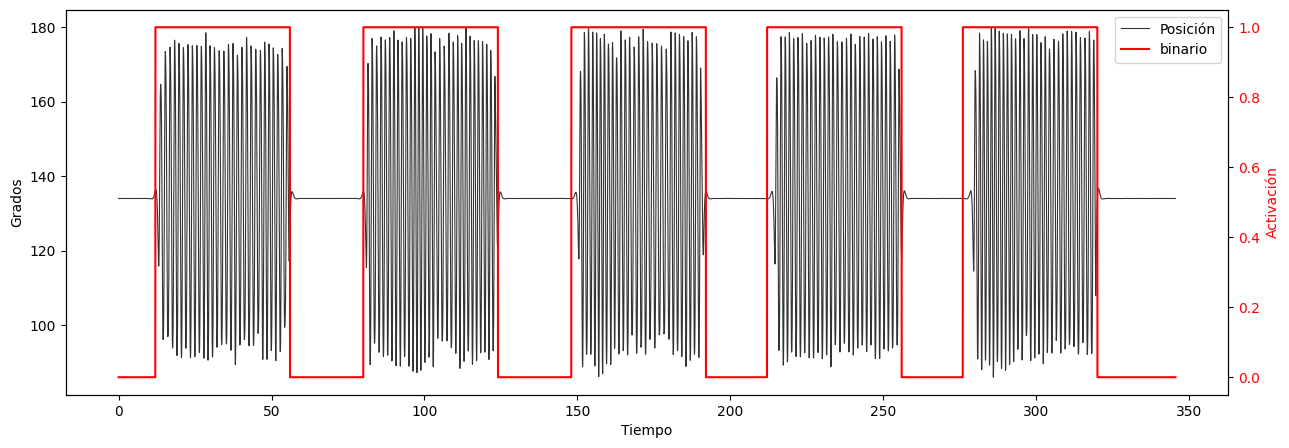

In [14]:
fig, ax1 = plt.subplots(figsize=(15, 5))

# Primer eje y
ax1.plot(t, scaled_pos, label="Posición", color='k', linewidth=0.8, alpha=0.8)
ax1.set_xlabel('Tiempo')
ax1.set_ylabel('Grados', color='k')
ax1.tick_params(axis='y', labelcolor='k')

# Segundo eje y
ax2 = ax1.twinx()
ax2.plot(t, binary_sig, label="binario", color='r', linewidth=1.5)
ax2.set_ylabel('Activación', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Añadir leyendas
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

### EMG

- Obtención de la envolvente

In [15]:
emg_agon = ib.normaliza(sgnl.sosfiltfilt(sosemg, signals[24, t_min:t_max]), options="std")
emg_anta = ib.normaliza(sgnl.sosfiltfilt(sosemg, signals[25, t_min:t_max]), options="std")

In [16]:

env_agon =  ib.obtenerEnvolvente(emg_agon, options="rms", param = 400)
env_anta =  ib.obtenerEnvolvente(emg_anta, options="rms", param = 400)


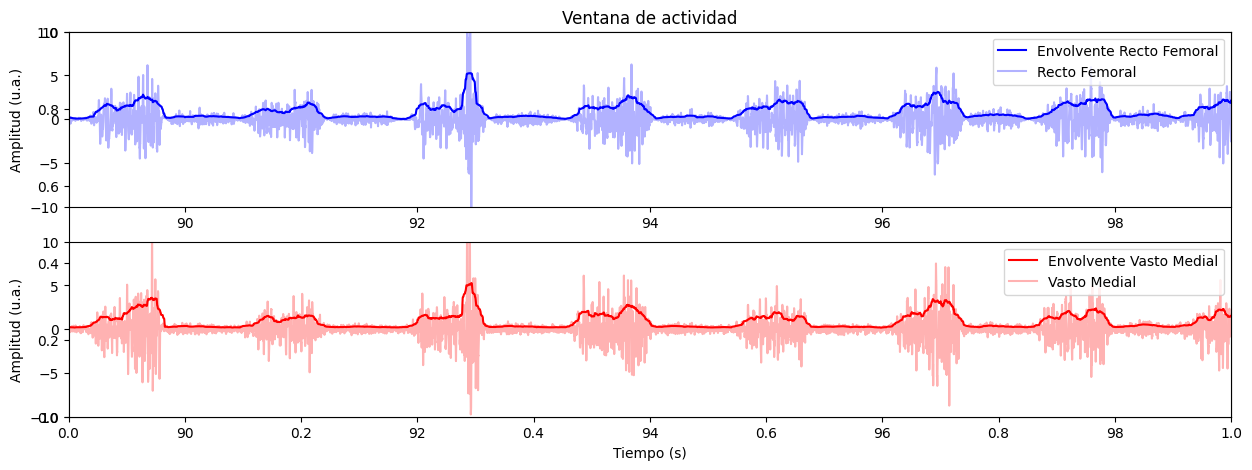

In [17]:
plt.figure(figsize = (15, 5))

plt.title("Ventana de actividad")

plt.subplot(2, 1, 1)
plt.plot(t, env_anta, c= "b", label = "Envolvente Recto Femoral")
plt.plot(t, emg_anta, alpha = 0.3, c = "b", label = "Recto Femoral")
plt.ylabel("Amplitud (u.a.)")

plt.legend(loc = "upper right")
plt.xlim(ventanas_actividad[1, 0]//fs + 10, ventanas_actividad[1, 0]//fs + 20)
plt.ylim(-10, 10)

plt.subplot(2, 1, 2)
plt.plot(t, env_agon, c = "r", label = "Envolvente Vasto Medial")
plt.plot(t, emg_agon, alpha = 0.3, c = "r", label = "Vasto Medial")
plt.ylabel("Amplitud (u.a.)")
plt.xlabel("Tiempo (s)")


plt.legend(loc = "upper right")

plt.xlim(ventanas_actividad[1, 0]//fs + 10, ventanas_actividad[1, 0]//fs + 20)
plt.ylim(-10, 10)
plt.show()


### ECG
- Obteneción de la variabilidad de la frecuencia cardiaca HRV

In [18]:
sosecg = sgnl.butter(4, [0.5*2/fs, 40*2/fs], "band", output="sos")

In [19]:
signals.shape

(28, 1658592)

In [20]:
sosecg = sgnl.butter(5, [10*2/fs, 50*2/fs], "band", output="sos")
ecg = sgnl.sosfiltfilt(sosecg, signals[20, t_min:t_max])

(100.0, 140.0)

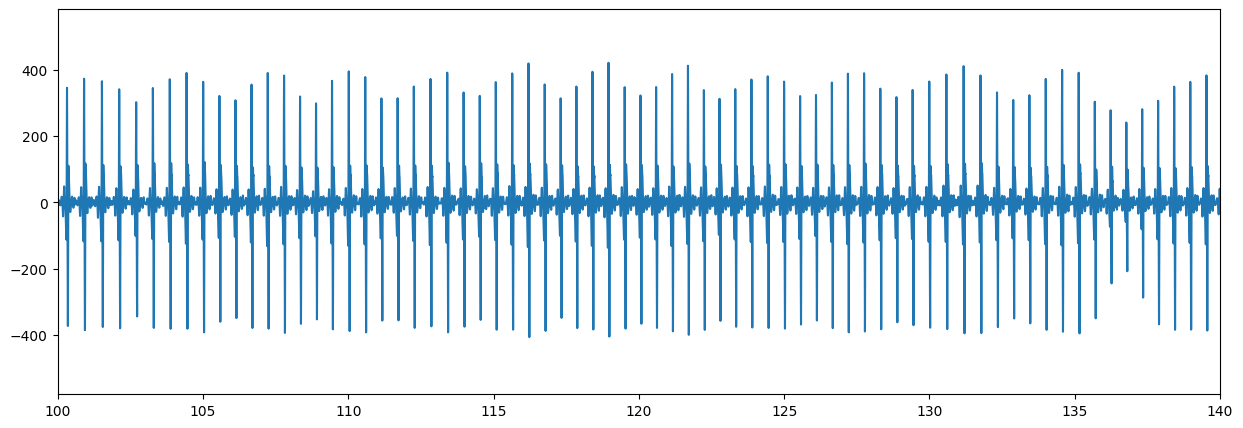

In [21]:
plt.figure(figsize=(15, 5))
plt.plot(t, (ecg))
plt.xlim(100, 140)

In [22]:
#ECG = ib.ECG(fs = fs)
#ECG.agregaSeniales(ecg, ["I"])
#ecg_2 = ECG.baseline_correction(ecg)
#ecg_2 = np.array(ecg_2["I"])
#ecg_2.shape
#ecg = ecg_2.flatten()

In [23]:
# Se necesita ajustar esta funcion a mano por ahora, puedes usar cualquier otra que te detecte picos R

idx_ecg, _ = ib.peakdetect(-(ecg), fs, long_ventana = int(fs * 0.8), distancia = fs // 4, thresh = [170, 500])

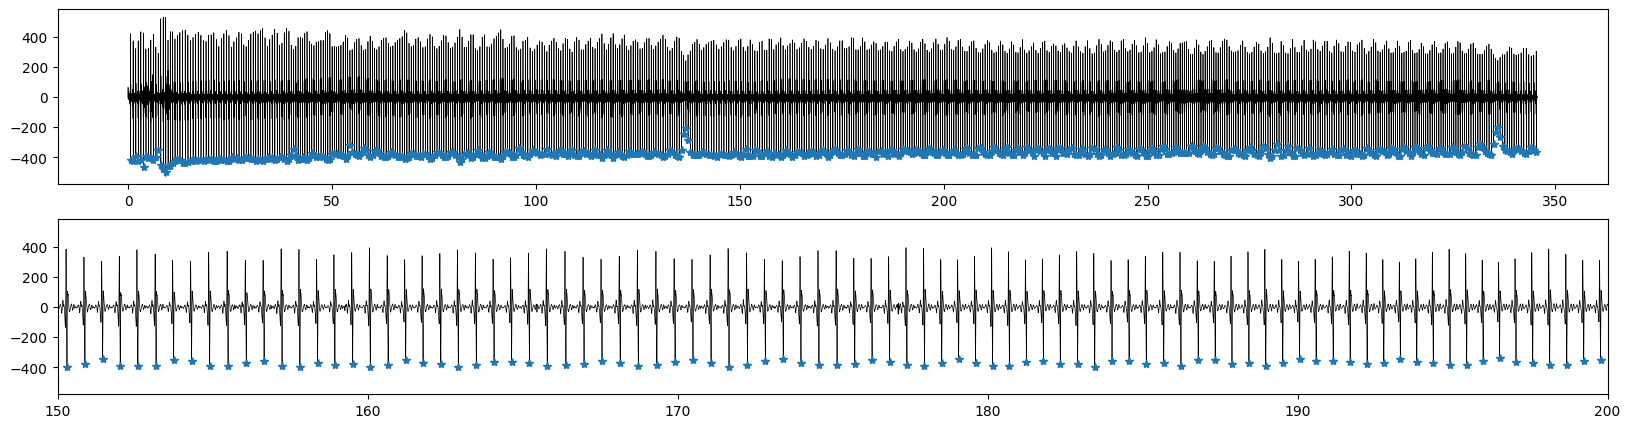

In [24]:
plt.figure(figsize=(20, 5))
plt.subplot(2, 1, 1)

plt.plot(t, ecg, c = "k",  linewidth = 0.5)
plt.plot(t[idx_ecg], ecg[idx_ecg], "*")


plt.subplot(2, 1, 2)
plt.plot(t, ecg, c = "k", linewidth = 0.5)
plt.plot(t[idx_ecg], ecg[idx_ecg], "*")
plt.xlim(150, 200)
plt.show()

ppm =  107.30203368749123
(614,) (1658591,)
(616,) (616,)


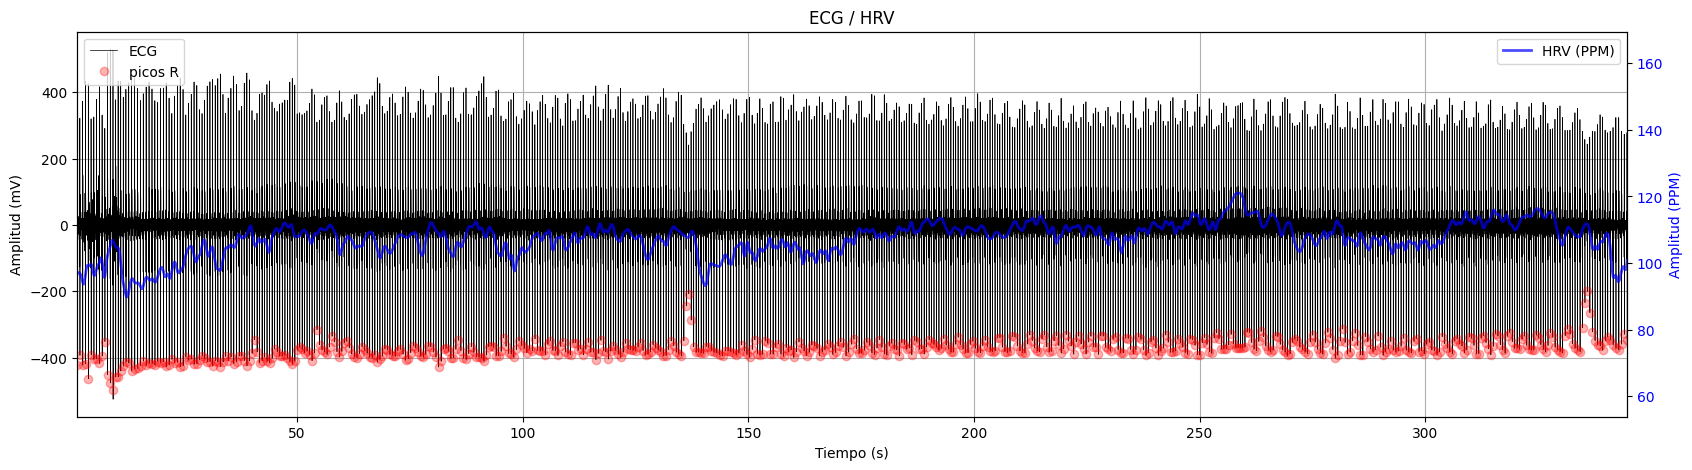

In [25]:

HRV, ppm = ib.getHRV(ecg, fs=fs, idx=idx_ecg[1:-1], siPlot=True)


### Respiración

- Obtención de la frecuencia respiratoria

1. Obtención de la frecuencia respiratoria con la banda de biopac
2. Obtención de la frecuencia respiratoria con la señal de ECG

In [26]:
# Esta es la banda de Biopac

sosresp = sgnl.butter(5, [(0.1*2)/fs, (1*2)/fs], "band", output="sos")
resp = sgnl.sosfiltfilt(sosresp, signals[19, t_min:t_max])


Text(0.5, 1.0, 'Respiración de la banda de Biopac')

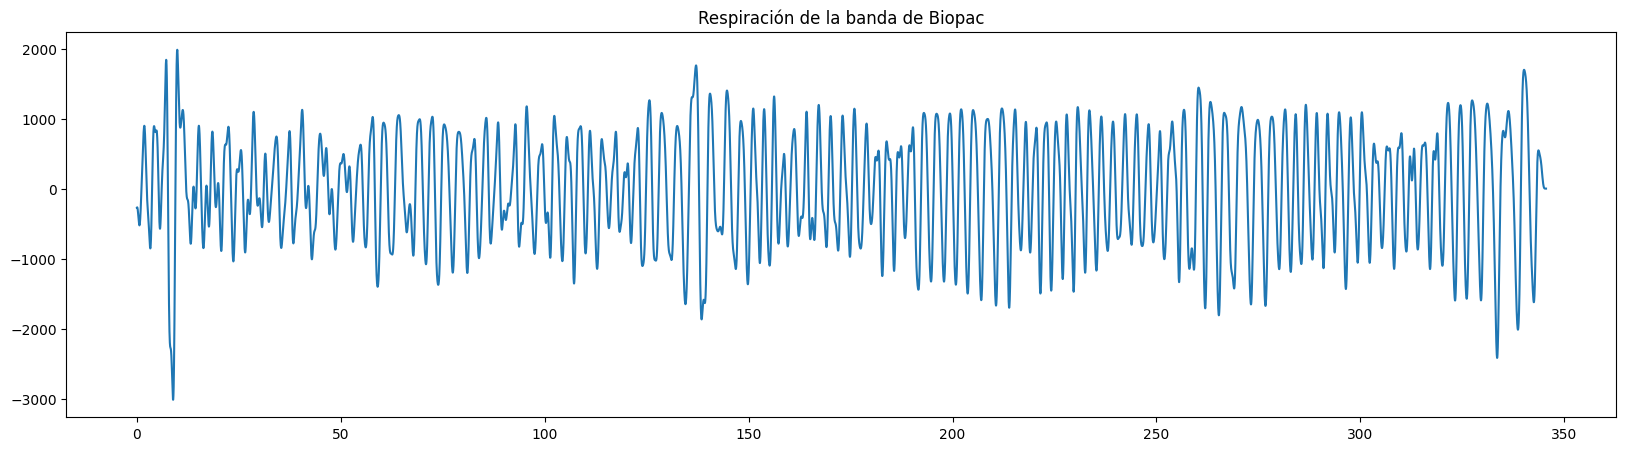

In [27]:
plt.figure(figsize = (20, 5))
plt.plot(t, resp -resp.mean())
plt.title("Respiración de la banda de Biopac")
#plt.ylim(-50, 50)

In [28]:
idx, _ = ib.peakdetect(resp, fs, long_ventana = 8000, distancia = 5000, thresh = [2, resp.max()])

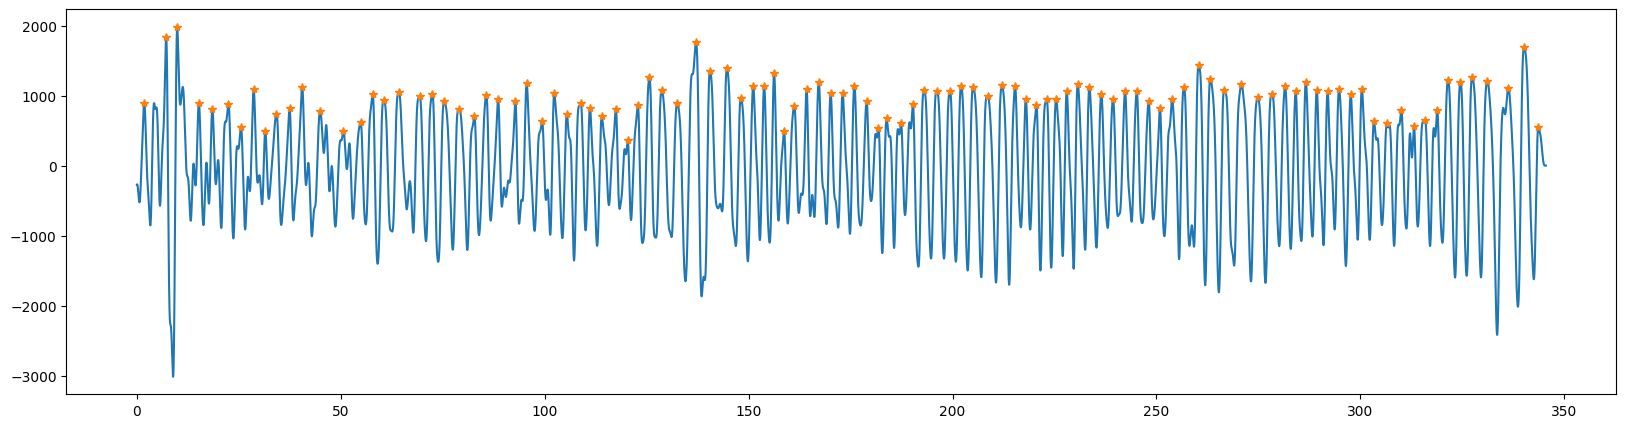

In [29]:
plt.figure(figsize=(20, 5))
plt.plot(t, resp)
plt.plot(t[idx], resp[idx], "*")
plt.show()

ppm =  19.418941781918797
(107,) (1658591,)
(109,) (109,)


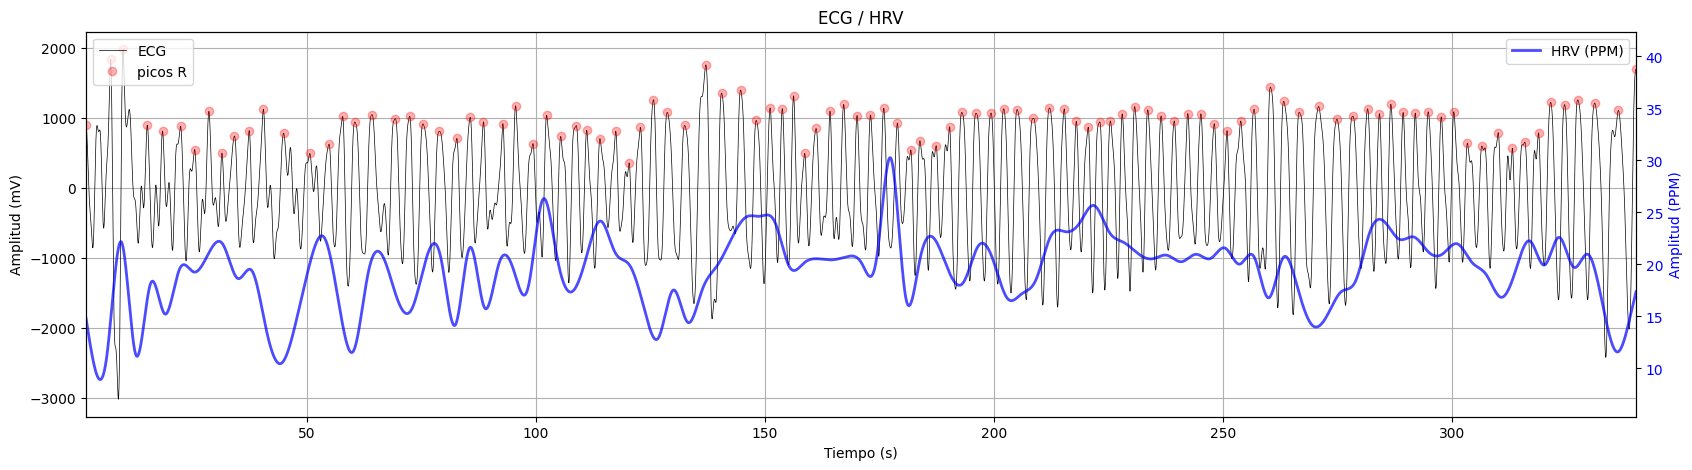

In [30]:
# Con las misma funcion de HRV se puede obtener la variabilidad de la frecuencia respiratoria

RRV, rpm= ib.getHRV(resp, fs=fs, idx=idx[:-1], siPlot=True)

In [31]:
sos_high = sgnl.butter(2, [(0.1*2)/fs], "high", output="sos")


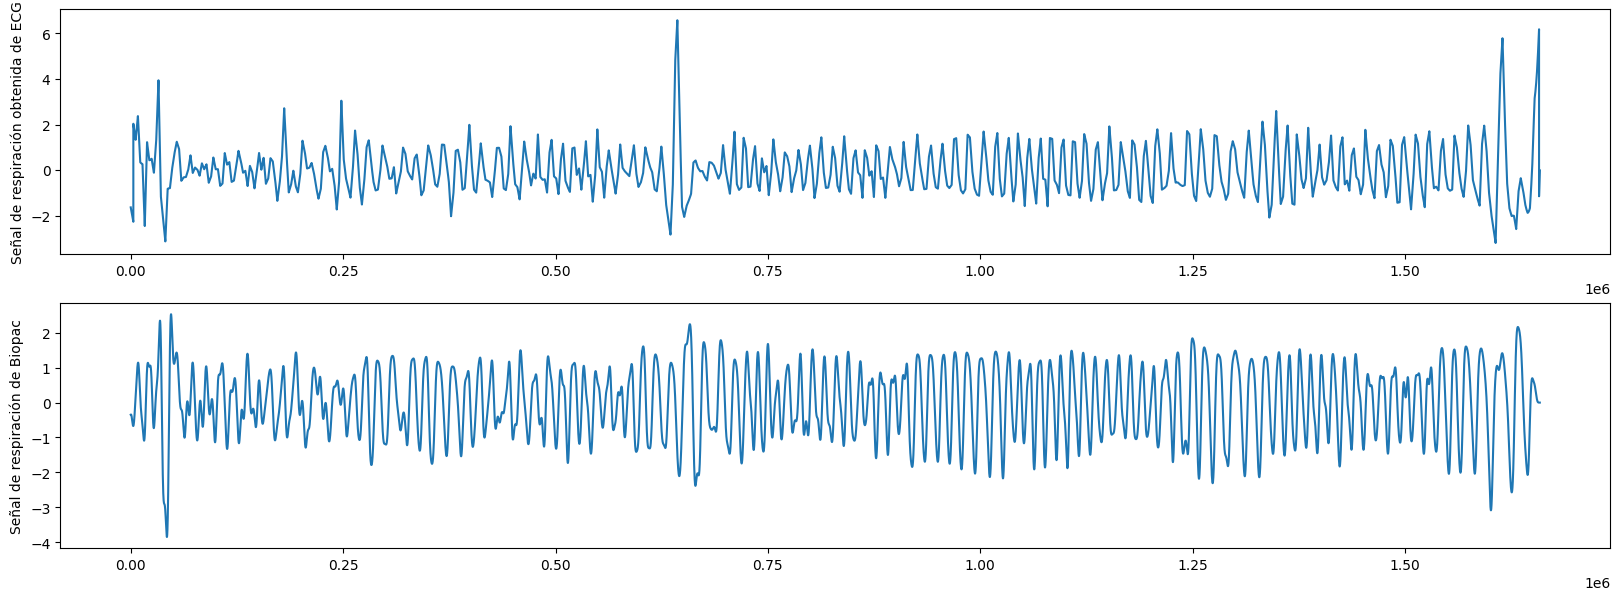

In [32]:



resp_sec = ecg[idx_ecg]
resp_ser_ceros = np.full_like(ecg, resp_sec.min())
x_resp_sec = np.linspace(0, 1, len(resp_sec))
x_resp = np.linspace(0, 1, len(ecg[idx_ecg[0]:idx_ecg[-1]]))

resp_sec_interp = interp1d(x_resp_sec, resp_sec)(x_resp)
resp_ser_ceros[idx_ecg[0]:idx_ecg[-1]] = resp_sec_interp

resp_ser_ceros -=  resp_ser_ceros.mean()
resp_ser_ceros = sgnl.sosfiltfilt(sos_high, resp_ser_ceros)


plt.figure(figsize=(20, 7))
plt.subplot(2, 1, 1)

plt.plot((resp_ser_ceros - resp_ser_ceros.mean()) / resp_ser_ceros.std())
plt.ylabel("Señal de respiración obtenida de ECG")

plt.subplot(2, 1, 2)

plt.plot((resp - resp.mean()) / resp.std())
plt.ylabel("Señal de respiración de Biopac")
plt.show()

# ¿A que se parecen?



In [33]:
idx, _ = ib.peakdetect(resp_ser_ceros, fs, long_ventana = 9200, distancia = 4000, thresh = [2, 100])


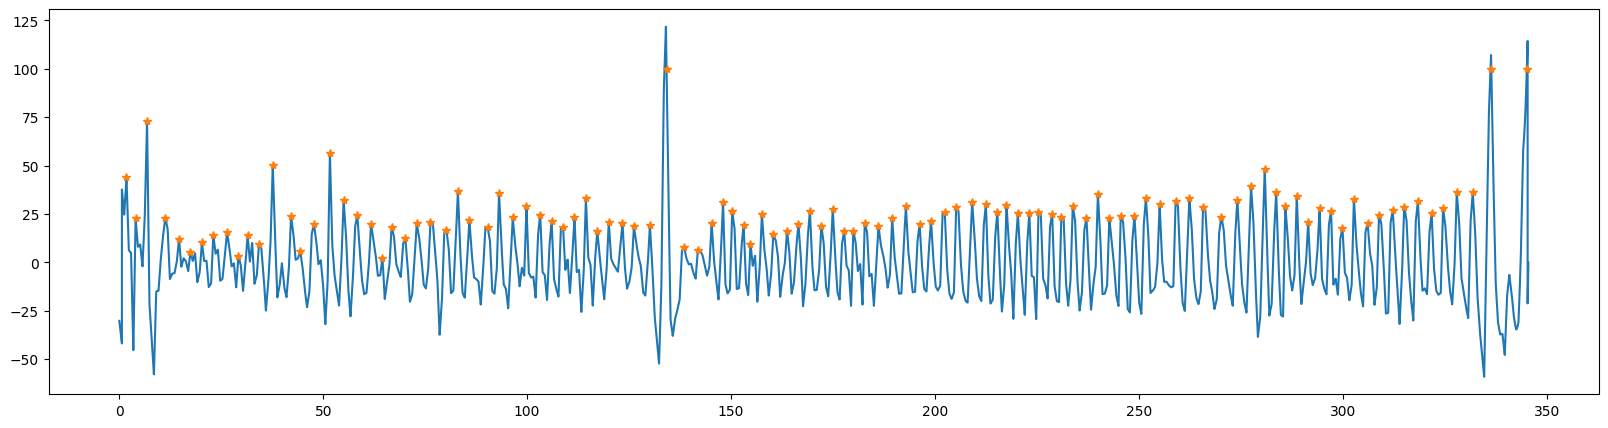

In [34]:
plt.figure(figsize=(20, 5))
plt.plot(t, resp_ser_ceros)
plt.plot(t[idx], resp_ser_ceros[idx], "*")
plt.show()

ppm =  19.9214115069531
(110,) (1658591,)
(112,) (112,)


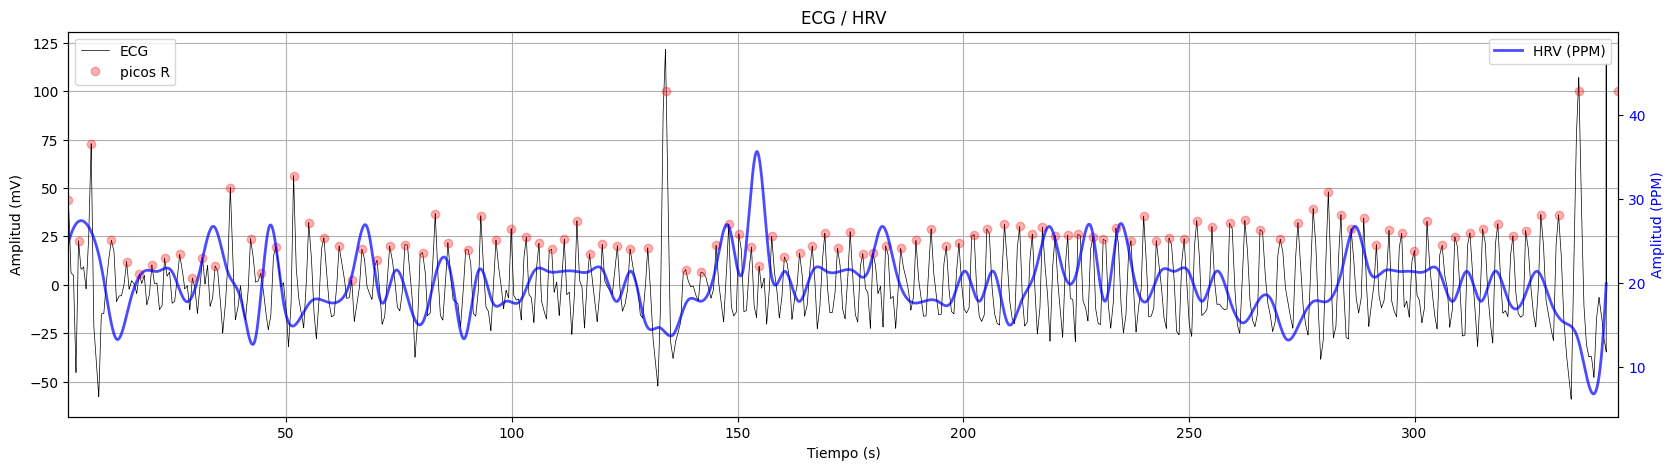

In [36]:
RRV, rpm= ib.getHRV(resp_ser_ceros, fs=fs, idx=idx[:], siPlot=True)

In [ ]:
resp = resp_ser_ceros

## Procesamiento de EEG

- ICA
- CAR
- FILTRADO
- ESTIMACIÓN DE BPTS

In [37]:
import mne
from mne.preprocessing import ICA
from sklearn import preprocessing
from mne.filter import notch_filter, filter_data

In [38]:
eeg = signals[0:16, t_min:t_max]
new_eeg = np.concatenate((eeg, emg_agon[np.newaxis,:], emg_anta[np.newaxis,:]), axis = 0)
print(new_eeg.shape)

(18, 1658591)


In [40]:
x,y,_,_,ch_names = ib.eloc_reader('../ToolFiles/eloc16_channels.txt')

ch_types = ["eeg"] * 18
info = mne.create_info(list(ch_names),sfreq=fs,ch_types=ch_types)
info.set_montage('standard_1020')

raw = mne.io.RawArray(new_eeg, info, first_samp=0, copy='auto', verbose=None)

raw.notch_filter(freqs = 60, notch_widths=2)

Creating RawArray with float64 data, n_channels=18, n_times=1658591
    Range : 0 ... 1658590 =      0.000 ...   345.540 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 58 - 62 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 58.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 58.25 Hz)
- Upper passband edge: 61.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 61.75 Hz)
- Filter length: 31681 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.3s


<RawArray | 18 x 1658591 (345.5 s), ~227.8 MB, data loaded>

In [41]:
raw_filt = raw.copy();
raw_filt.load_data().filter(l_freq=0.1, h_freq=200, verbose = False);


In [42]:
#%matplotlib qt

Using matplotlib as 2D backend.


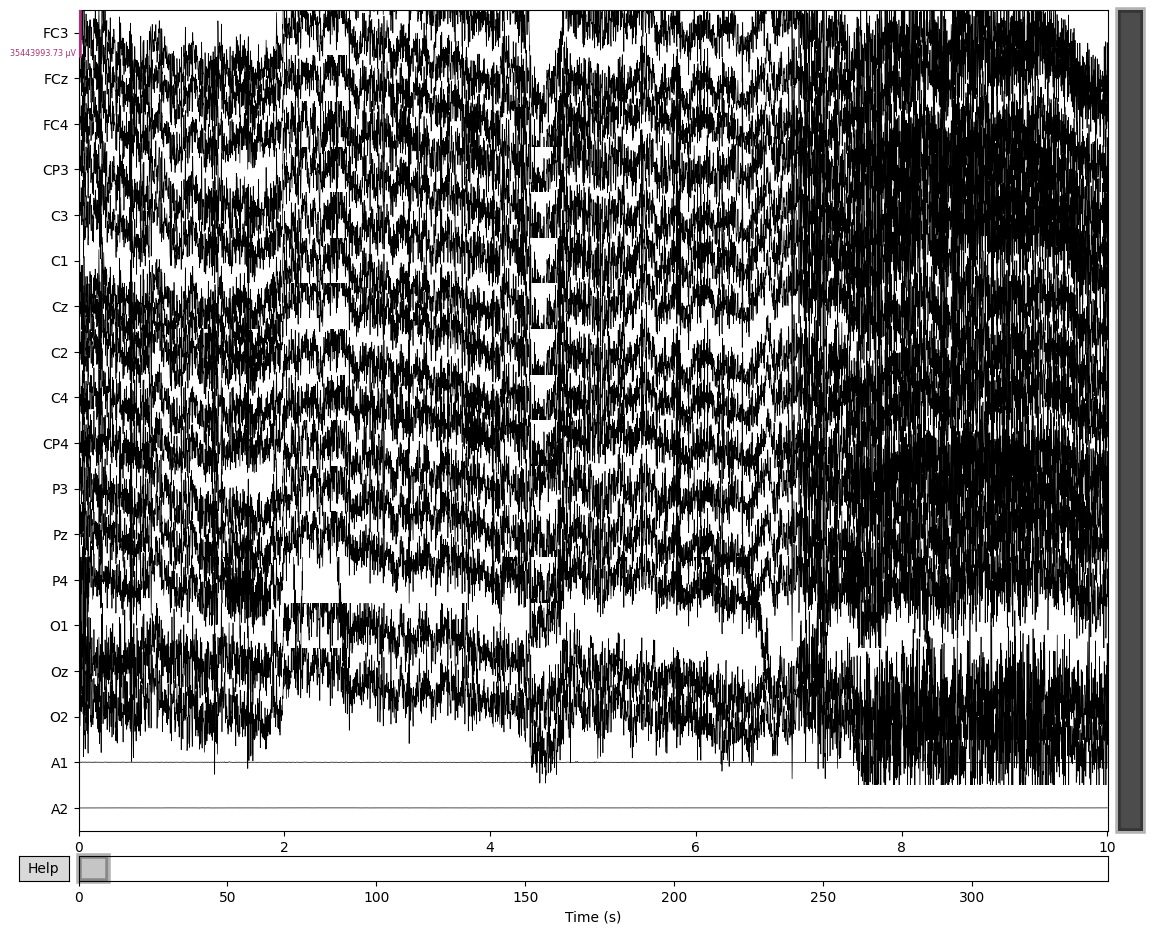

In [43]:
raw_filt.plot(duration=10, n_channels=18, scalings = "auto");

In [44]:
#%matplotlib inline


In [45]:

ica=ICA(n_components=18, max_iter='auto', random_state=97);
ica.fit(raw_filt)


Fitting ICA to data using 18 channels (please be patient, this may take a while)
Selecting by number: 18 components
Fitting ICA took 19.1s.


<ICA | raw data decomposition, method: fastica (fit in 27 iterations on 1658591 samples), 18 ICA components (18 PCA components available), channel types: eeg, no sources marked for exclusion>

Creating RawArray with float64 data, n_channels=18, n_times=1658591
    Range : 0 ... 1658590 =      0.000 ...   345.540 secs
Ready.


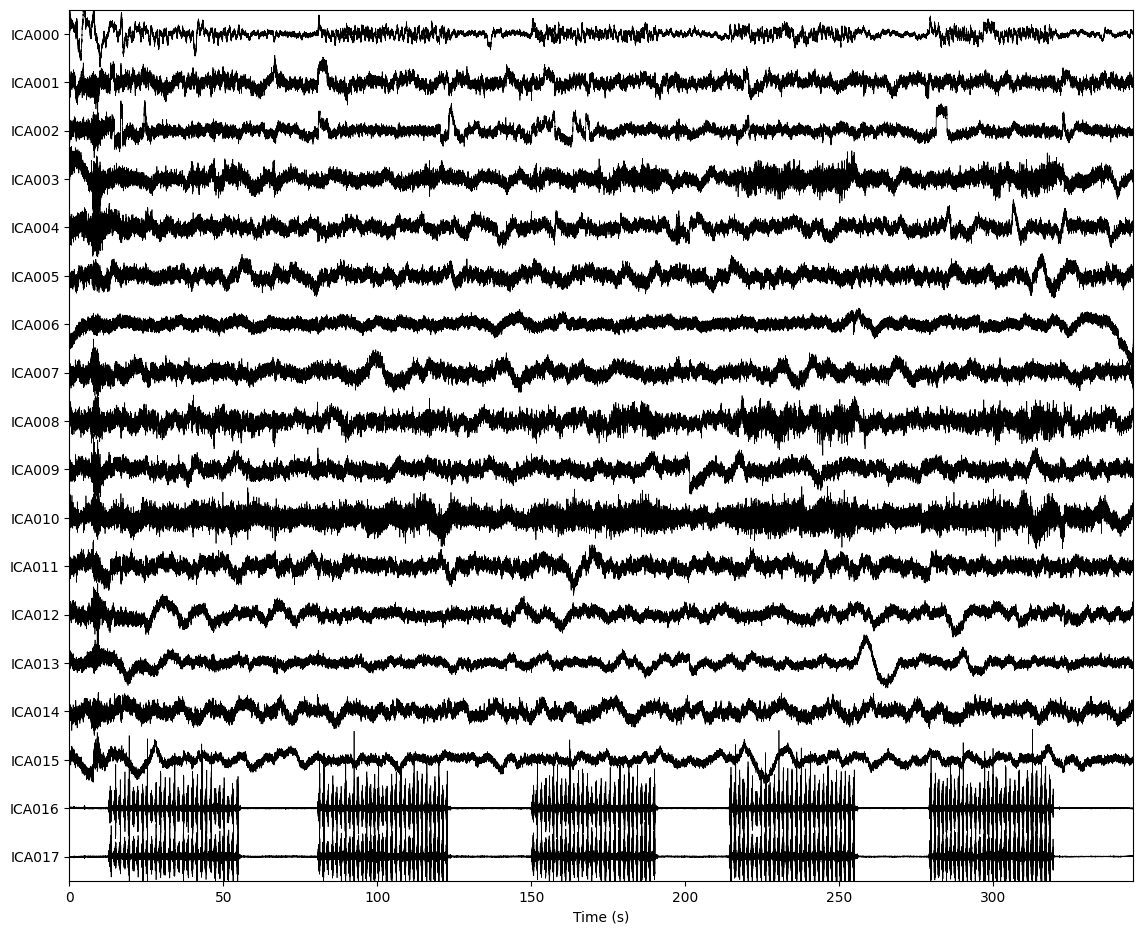

In [46]:

ica.plot_sources(raw_filt, show_scrollbars=False, stop=650);                                                         

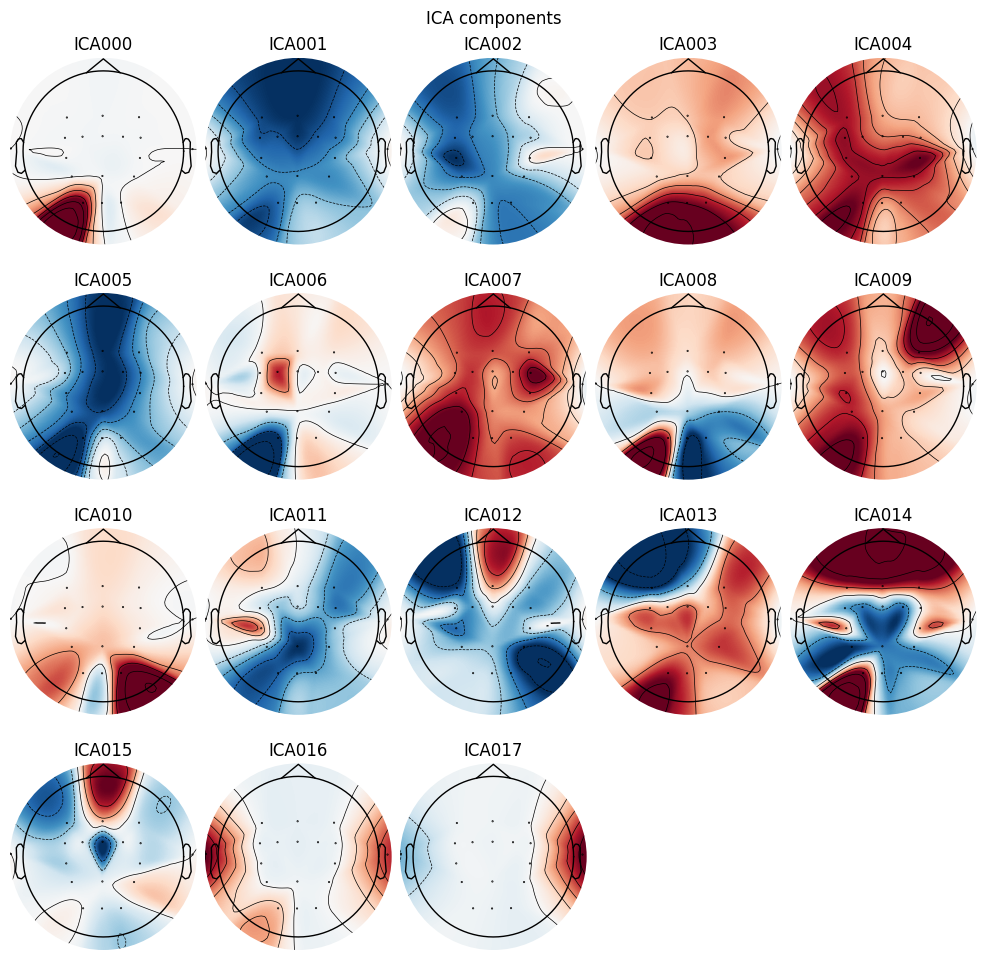

In [47]:
ica.plot_components();

In [49]:
icas=[0, 2, 14, 15]      
ica.exclude = icas
ica.apply(raw_filt)

Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 4 ICA components
    Projecting back using 18 PCA components


<RawArray | 18 x 1658591 (345.5 s), ~227.8 MB, data loaded>

In [50]:
rawnp=raw_filt.copy();
rawnp.set_eeg_reference(ref_channels='average', verbose = False);

iir_params = dict(order=4, ftype='ellip',rp=0.1, rs=40, output='sos', verbose = False)
iir_params = mne.filter.construct_iir_filter(iir_params, [2, 80], None, sfreq=fs, btype='bandpass', return_copy=False, verbose = False)
rawnp.filter(l_freq=2, h_freq=80, method='iir', iir_params=iir_params, verbose = False);

eeg_mne=preprocessing.StandardScaler().fit_transform(rawnp.get_data())


In [ ]:
#%matplotlib qt

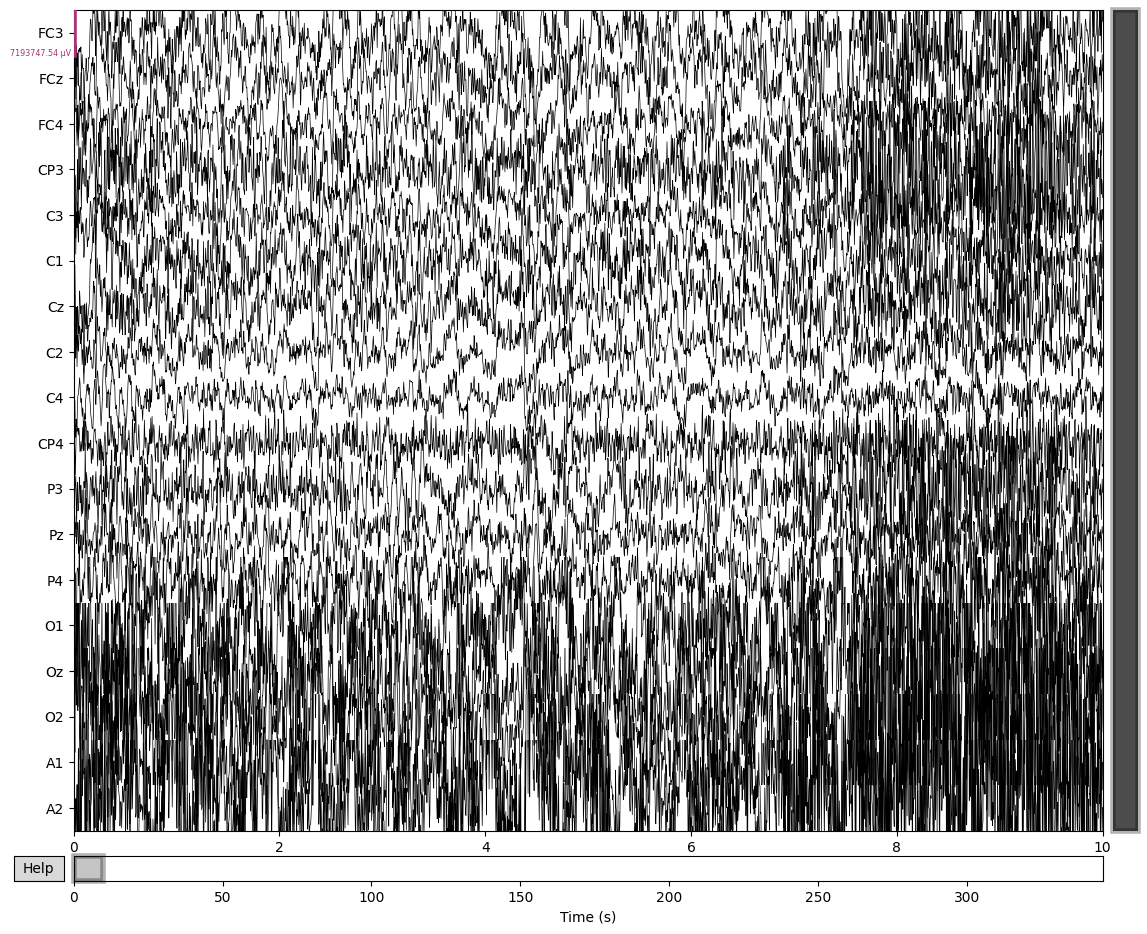

In [52]:
rawnp.plot(duration=10, n_channels=18, scalings = "auto");

In [53]:
#%matplotlib inline



In [54]:
eeg_mne.shape

(18, 1658591)

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 0.833 (s)
Plotting power spectral density (dB=True).


C:\Users\fercy\AppData\Local\Temp\ipykernel_21368\1452027091.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  a =  mne.viz.plot_raw_psd(rawnp, fmin=0.1, fmax=100, n_fft=4000, picks='all', proj=False, n_overlap=0, reject_by_annotation=True, verbose=None);
c:\Users\fercy\miniconda3\envs\ibero\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


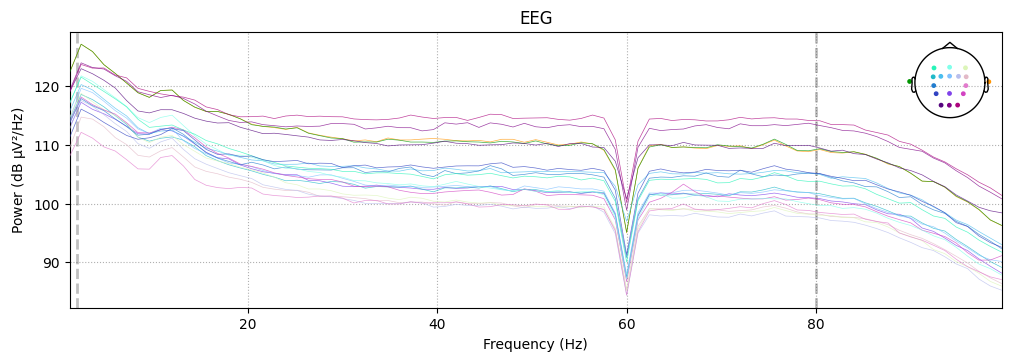

In [55]:
a =  mne.viz.plot_raw_psd(rawnp, fmin=0.1, fmax=100, n_fft=4000, picks='all', proj=False, n_overlap=0, reject_by_annotation=True, verbose=None);

In [56]:
def lap_filter(eeg, channel_name, neighbor_names, channel_names):
    channel_idx = channel_names.index(channel_name)
    neighbor_indices = [channel_names.index(name) for name in neighbor_names]

    eeg[channel_idx, :] -= np.mean(eeg[neighbor_indices, :], axis=0)
    return eeg



In [83]:
nombres_canales = ["FC3", "FCz", "FC4", "Cp3", "C3", "C1", "Cz", "C2", "C4", "Cp4", "P3", "Pz", "P4", "O1", "Oz", "O2"]
#                    0      1       2     3     4     5     6     7     8     9     10    11    12    13    14    15



In [84]:
eeg_mne = lap_filter(eeg_mne, "C3", ["C1", "FC3", "Cp3"], nombres_canales)

eeg_mne = lap_filter(eeg_mne, "C1", ["Cz", "FC3"], nombres_canales)
eeg_mne = lap_filter(eeg_mne, "C2", ["Cz", "FC4", "C4"], nombres_canales)

eeg_mne = lap_filter(eeg_mne, "Cz", ["C1", "FCz", "C2", "Pz"], nombres_canales)
eeg_mne = lap_filter(eeg_mne, "C4", ["C2", "FC4", "Cp4"], nombres_canales)


In [59]:

def plot_avgBPTS(BPTS, axis=None):
    norm = ib.normaliza(BPTS)
    title = ["mu 12 - 15 Hz", "beta 12 - 30 Hz", "gamma 30 - 100 Hz"]

    if axis is None:
        fig, axes = plt.subplots(1, 3, figsize=(15, 3))
    else:
        axes = axis

    for idx, ax in enumerate(axes):
        if idx < len(norm):
            a, b = mne.viz.plot_topomap(norm[idx], info, axes=ax, show=False, cmap='Spectral_r')
            ax.set_title(title[idx])

    if axis is None:
        fig.tight_layout()
        plt.show()

    return axes
    

In [60]:
S, f, n = ib.sliding_PSD(eeg_mne, N = fs * 2, Fs = fs, Nfft = 15_000, step = 0.05)

alfa = ib.band_estimation(S, f, band = "alpha")
mu = ib.band_estimation(S, f, band = [10, 15])
beta = ib.band_estimation(S, f, band = "beta")
gamma = ib.band_estimation(S, f, band = "gamma")




In [61]:
N = eeg_mne.shape[1]
t_f = t[-1]
M = S.shape[1]
BPTS_fs = M/t_f
print(BPTS_fs)

9.943867984251682


In [62]:
original_signal = mu[0,:]

nre_fs = 100
original_axis = np.arange(0, t_f, 1 / BPTS_fs)
original_axis = original_axis[0:alfa.shape[1]]
target = np.arange(0, t_f, 1 / nre_fs)


target = np.clip(target, original_axis.min(), original_axis.max())


interp_func = interp1d(original_axis, alfa[:,:], kind='cubic')
BPTalfa = interp_func(target)

interp_func = interp1d(original_axis, mu[:,:], kind='cubic')
BPTmu = interp_func(target)

interp_func = interp1d(original_axis, beta[:,:], kind='cubic')
BPTbeta = interp_func(target)

interp_func = interp1d(original_axis, gamma[:,:], kind='cubic')
BPTgamma = interp_func(target)



In [63]:
BPTalfa.shape

(18, 34554)

# Las BPTs

Text(0.5, 1.0, 'BPTS Cz Mu')

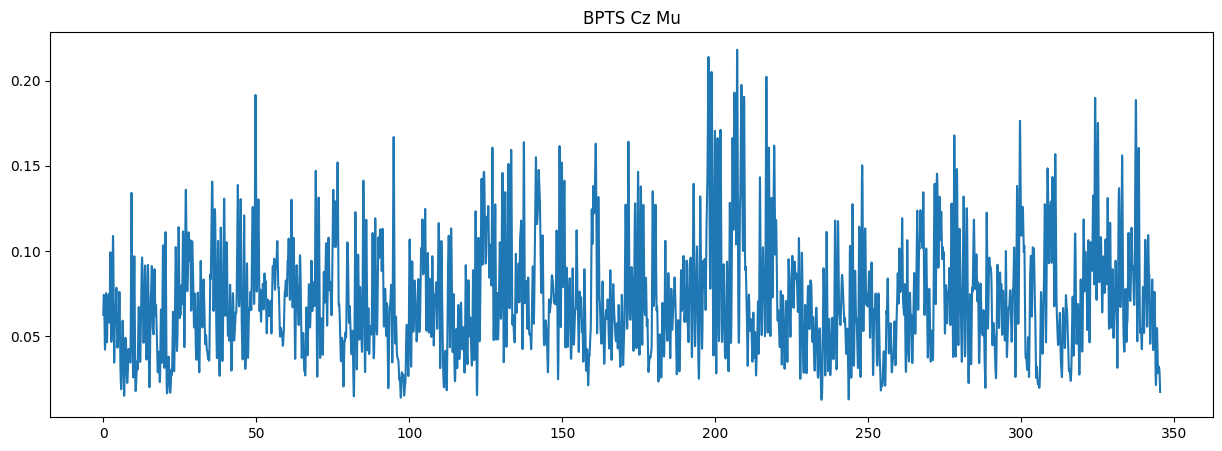

In [71]:
plt.figure(figsize=(15, 5))
plt.plot(target, BPTmu[5, :])
plt.title("BPTS Cz Mu")

In [81]:
BPTalfa.shape

(18, 34554)

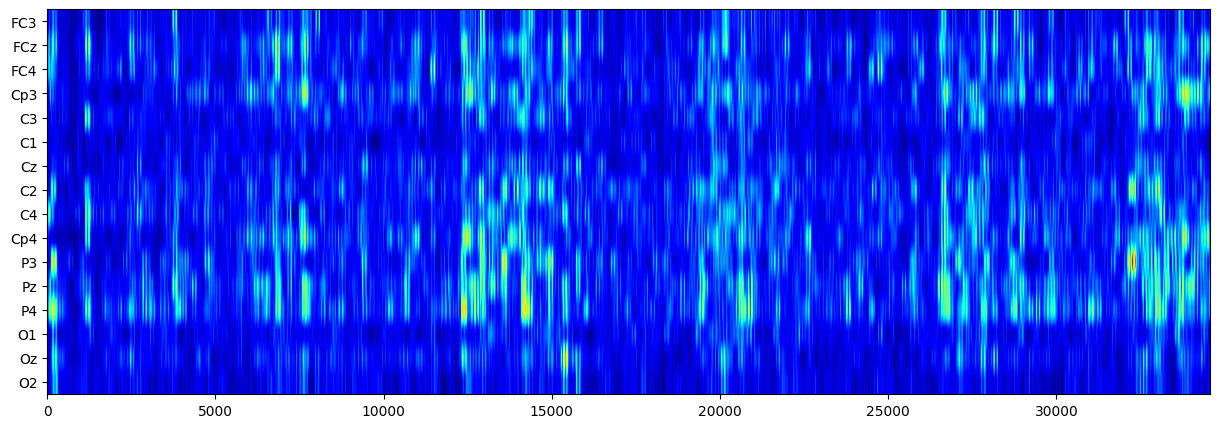

In [87]:
plt.figure(figsize=(15, 5))
plt.imshow(BPTmu[:-2], aspect='auto', cmap='jet')
plt.yticks(np.arange(0, 16, 1), nombres_canales);

# Guardar señales

Se guardan las señales para su procesamiento posterior

In [64]:
data = [HRV, RRV, env_agon, env_anta, torq, pos, binary_sig]
data_transposed = list(map(list, zip(*data)))
df = pd.DataFrame(data=data_transposed, columns=["HRV", "RRV", "EnvAnta", "EnvAgo", "Torque", "Posicion", "Binaria"])

In [65]:
new_frequency = 100

original_time = t

new_time = np.arange(0, t[-1], 1/new_frequency)

df_interpolated = pd.DataFrame()
for column in df.columns:
    f = interp1d(original_time, df[column], kind="cubic")
    new_data = f(new_time)
    df_interpolated[column] = new_data

    

In [66]:
new_data.shape

(34554,)

In [67]:
for canal in range(16):
    df_interpolated[f"alfa_{ch_names[canal]}"] = BPTalfa[canal, :]
    df_interpolated[f"mu_{ch_names[canal]}"] = BPTmu[canal, :]
    df_interpolated[f"beta_{ch_names[canal]}"] = BPTbeta[canal, :]
    df_interpolated[f"gamma_{ch_names[canal]}"] = BPTgamma[canal, :]
    


In [68]:
df_interpolated.head()

HRV        RRV   EnvAnta    EnvAgo     Torque   Posicion  Binaria  \
0  107.302034  19.921412  0.189435  0.015964  -0.029437  -8.646760      0.0   
1  106.939766  19.957487  0.196852  0.017512  50.792528 -10.156367      0.0   
2  106.584678  19.993462  0.205710  0.018181  70.560694  -7.163205      0.0   
3  106.236703  20.029338  0.224563  0.023270  70.325361  -2.930753      0.0   
4  105.895775  20.065114  0.230639  0.024195  64.434833  -1.310057      0.0   

   alfa_FC3    mu_FC3  beta_FC3  ...   beta_O1  gamma_O1   alfa_Oz     mu_Oz  \
0  0.120034  0.137753  0.252941  ...  0.192186  0.344610  0.014370  0.029018   
1  0.122073  0.136418  0.249910  ...  0.190073  0.349616  0.014886  0.030530   
2  0.123621  0.134811  0.246702  ...  0.187710  0.353928  0.015463  0.032219   
3  0.124704  0.132951  0.243331  ...  0.185122  0.357582  0.016099  0.034068   
4  0.125347  0.130860  0.239812  ...  0.182336  0.360614  0.016788  0.036060   

    beta_Oz  gamma_Oz   alfa_O2     mu_O2   beta_O2  gamma_O2  
0  0.174373  0.576322  0.055671  0.068012  0.219767  0.495710  
1  0.175537  0.570258  0.056545  0.067965  0.219227  0.492344  
2  0.176637  0.564007  0.057228  0.067816  0.218575  0.488909  
3  0.177673  0.557586  0.057730  0.067571  0.217811  0.485411  
4  0.178646  0.551012  0.058062  0.067239  0.216933  0.481857  

[5 rows x 71 columns]

In [ ]:
df_interpolated.to_csv(filename + 'Pre.csv', index=False)

In [ ]:
df_eeg = pd.DataFrame(data=eeg_mne.T, columns=ch_names)
df_eeg["bin"] = binary_sig
df_eeg.to_csv(filename + 'EEG.csv', index=False)
